# Parking Robot with Continuous Dynamics

Richard M. Murray, 4 Mar 2020

## Problem description
This example illustrates the use of TuLiP to synthesize a reactive
controller for system whose dynamics are described by a discrete
transition system.  It is an extension of the `robot_simple_discrete` by including continuous dynamics.

## Notebook setup

The first section of the code should import all of the packages that are needed for the system (including TuLiP).  There are also various comments that can be placed here to configure the Jupyter notebook to display graphics and moves inline.

In [1]:
# Jupyter notebook setup
%matplotlib inline
from IPython.display import HTML        # for inline animations

# Import TuLiP (including the main modules)
import tulip as tlp
import tulip.hybrid, tulip.abstract, tulip.spec, tulip.synth
import polytope as poly                 # optional polytop package

# Additional packages that are used (optional)
import numpy as np
import random
import matplotlib.pyplot as plt

/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/mathset.py:719: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/mathset.py:719: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/labeled_graphs.py:1218: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/labeled_graphs.py:1226: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/python3.8/site-packages/tulip-1.4.0-py3.8.egg/tulip/transys/labeled_graphs.py:1218: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/kimiahassibi/Desktop/Caltech/SURF2023/env/lib/pyt

## System model

The system model is an input/output model that takes inputs from the controller and describes how the system state evolves.  You can descibe the system in one of several ways:

* Directly as a transition system, using `tulip.transys.FTS()`
* As an LTL formula that describes how the state evolves
* Using a domain specific language (such as `tulip.gridworld`)
* As a piecewise affine system, with continuous dynamics and a (automatically computed) discrete abstraction

We consider here the case of a piecewwise affine (PWA) system since it is more general than the others.  See `robot_simple_discrete.ipynb` for transition system example.

### Continuous dynamics

In [2]:
# Continuous state space: 2D box of size 3 x 2
cont_state_space = poly.box2poly([[0., 3.], [0., 2.]])

# System dynamics (continuous state, discrete time): simple integrator
A = np.array([[1.0, 0.], [ 0., 1.0]])
B = np.array([[0.1, 0.], [ 0., 0.1]])
E = np.array([[1,0], [0,1]])

# Available control, possible disturbances
U = poly.box2poly(np.array([[-1., 1.], [-1., 1.]]))
W = poly.box2poly(np.array([[-0.01, 0.01], [-0.01, 0.01]]))

# Construct the LTI system describing the dynamics
sys_dyn = tlp.hybrid.LtiSysDyn(A, B, E, None, U, W, cont_state_space)

print(sys_dyn)

A =
   [[1. 0.]
    [0. 1.]]
B =
   [[0.1 0. ]
    [0.  0.1]]
E =
   [[1 0]
    [0 1]]
K =
   [[0.]
    [0.]]
Uset =
   Single polytope 
     [[ 1.  0.] |    [[1.]
      [ 0.  1.] x <=  [1.]
      [-1. -0.] |     [1.]
      [-0. -1.]]|     [1.]]
   
Wset =
   Single polytope 
     [[ 1.  0.] |    [[0.01]
      [ 0.  1.] x <=  [0.01]
      [-1. -0.] |     [0.01]
      [-0. -1.]]|     [0.01]]
   


### Proposition preserving partitions

For a continuous system we need to identify regions of the state space 
in which the atomic propositions that we will use in formulas will hold.

In [3]:
# Define atomic propositions for relevant regions of state space
cont_props = {}
cont_props['home'] = poly.box2poly([[0., 1.], [0., 1.]])
cont_props['lot'] = poly.box2poly([[2., 3.], [1., 2.]])

# Compute the proposition preserving partition of the continuous state space
cont_partition = tlp.abstract.prop2part(cont_state_space, cont_props)
print(cont_partition)


----------------------------------------
Proposition Preserving Partition:
----------------------------------------

Domain: Single polytope 
  [[ 1.  0.] |    [[ 3.]
   [ 0.  1.] x <=  [ 2.]
   [-1. -0.] |     [-0.]
   [-0. -1.]]|     [-0.]]

Region: 0
	 Propositions: lot
	 Polytope number 1:
	 Single polytope 
		  [[ 1.  0.] |    [[ 3.]
		   [ 0.  1.] x <=  [ 2.]
		   [-1. -0.] |     [-2.]
		   [-0. -1.]]|     [-1.]]
		

Region: 1
	 Propositions: home
	 Polytope number 1:
	 Single polytope 
		  [[ 1.  0.] |    [[1.]
		   [ 0.  1.] x <=  [1.]
		   [-1. -0.] |     [0.]
		   [-0. -1.]]|     [0.]]
		

Region: 2
	 Propositions: {}
	 Polytope number 1:
	 Single polytope 
		  [[ 0.  1.] |    [[ 2.]
		   [-0. -1.] x <=  [ 0.]
		   [-1. -0.] |     [-1.]
		   [ 1.  0.]]|     [ 2.]]
		
	 Polytope number 2:
	 Single polytope 
		  [[ 1.  0.] |    [[ 3.]
		   [-0. -1.] x <=  [ 0.]
		   [-1. -0.] |     [-2.]
		   [ 0.  1.]]|     [ 1.]]
		
	 Polytope number 3:
	 Single polytope 
		  [[ 0.  1.] |   

### Discrete abstraction

Finally, we compute a discrete abstraction for the system

In [4]:
disc_dynamics = tlp.abstract.discretize(
    cont_partition, sys_dyn, 
    closed_loop=False, conservative=True, 
    N=5, min_cell_volume=0.1, plotit=False
)

	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \cap Pre(sj), so discard intersection
	 discarded non-empty intersection: consider reducing min_cell_volume
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre

	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too small: si \ Pre(sj), so not reached it
	 too smal

Total abstraction time: 48.43[sec]


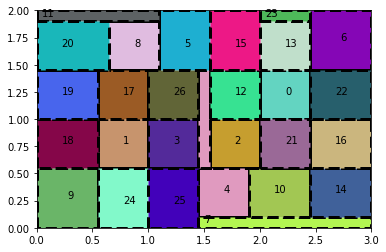


----------------------------------------
Proposition Preserving Partition:
----------------------------------------

Domain: Single polytope 
  [[ 1.  0.] |    [[ 3.]
   [ 0.  1.] x <=  [ 2.]
   [-1. -0.] |     [-0.]
   [-0. -1.]]|     [-0.]]

Region: 0
	 Propositions: lot
	 Polytope number 1:
	 Single polytope 
		  [[-0.  1.] |    [[ 1.45]
		   [ 1.  0.] x <=  [ 2.45]
		   [-1.  0.] |     [-2.  ]
		   [ 0. -1.]]|     [-1.  ]]
		

Region: 1
	 Propositions: home
	 Polytope number 1:
	 Single polytope 
		  [[ 0.  1.] |    [[ 1.  ]
		   [ 1. -0.] x <=  [ 1.  ]
		   [-1.  0.] |     [-0.55]
		   [ 0. -1.]]|     [-0.55]]
		

Region: 2
	 Propositions: {}
	 Polytope number 1:
	 Single polytope 
		  [[ 1.  0.] |    [[ 2.  ]
		   [ 0. -1.] x <=  [-0.55]
		   [-0.  1.] |     [ 1.  ]
		   [-1. -0.]]|     [-1.55]]
		

Region: 3
	 Propositions: {}
	 Polytope number 1:
	 Single polytope 
		  [[ 1.  0.] |    [[ 1.45]
		   [ 0. -1.] x <=  [-0.55]
		   [-1. -0.] |     [-1.  ]
		   [ 0.  1.]]|     [ 1. 

In [5]:
disc_dynamics.plot()
print(disc_dynamics)

## Environment model

The environment describes the external dynamics that the system should respond to.  In TuLiP, it should be a discrete-state system whose behaviors can be specified in a number of ways:



In [6]:
# Specifications
# Environment variables and assumptions
env_vars = {'park'}
env_init = set()                # empty set
env_prog = '!park'
env_safe = set()                # empty set

## System specification

In [7]:
# System variables and requirements
sys_vars = {'X0reach'}
sys_init = {'X0reach'}
sys_prog = {'home'}               # []<>home
sys_safe = {'(X(X0reach) <-> lot) || (X0reach && !park)'}
sys_prog |= {'X0reach'}

# Create the specification
specs = tlp.spec.GRSpec(env_vars, sys_vars, env_init, sys_init,
                    env_safe, sys_safe, env_prog, sys_prog)
specs.qinit = '\E \A'

## Controller synthesis

removed 0 nodes from 27 total


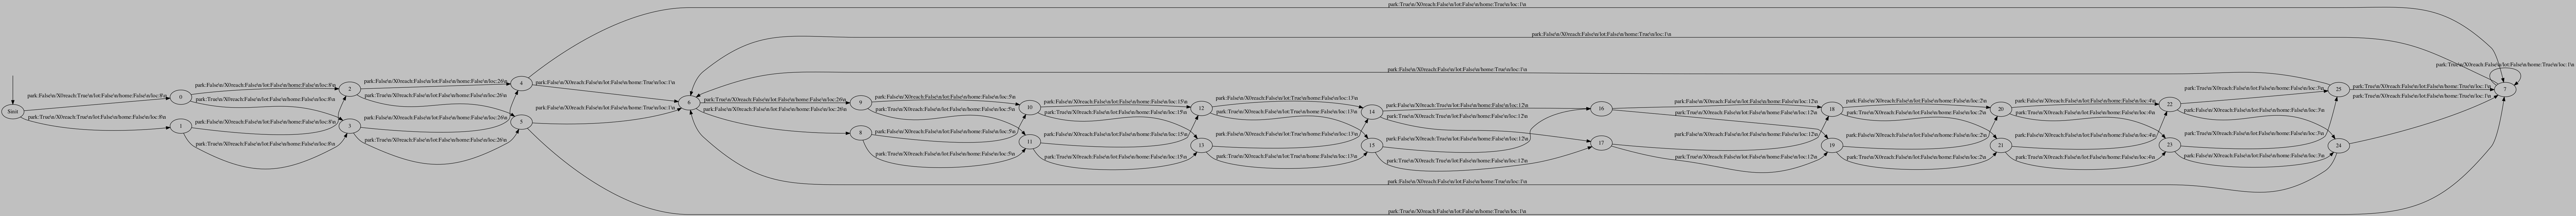

In [8]:
ctrl = tlp.synth.synthesize(specs,
                        sys=disc_dynamics.ts, ignore_sys_init=True)
assert ctrl is not None, 'unrealizable'
ctrl.plot();

## Simulation

In [9]:
# Number of time steps to simulate
T = 50

# Pick a random parking signal
randParkSignal = [random.randint(0, 1) for b in range(1, T + 1)]

# Set up parameters for get_input()
disc_dynamics.disc_params['conservative'] = True
disc_dynamics.disc_params['closed_loop'] = False

In [10]:
# Initialization:
#     pick initial continuous state consistent with
#     initial controller state (discrete)
u, v, edge_data = list(ctrl.edges('Sinit', data=True))[1]
s0_part = edge_data['loc']
init_poly_v = poly.extreme(disc_dynamics.ppp[s0_part][0])
x_init = sum(init_poly_v) / init_poly_v.shape[0]

s0_part = tlp.abstract.find_controller.find_discrete_state(
    [x_init[0], x_init[1]], disc_dynamics.ppp)
print("Initial system  state:", x_init[0], x_init[1], "(s%d)" % s0_part)
print("Initial controller discrete state:", 'Sinit')

# Create a deterministic controller from the initial condition
ctrl = tlp.synth.determinize_machine_init(ctrl, {'loc': s0_part})

# Set up initial condition for simulation
x = [x_init[0]]
y = [x_init[1]]
N = disc_dynamics.disc_params['N']
s, dum  = ctrl.reaction('Sinit', {'park': randParkSignal[0]})
print("Initialize, Park signal = %d: new controller state" % randParkSignal[0], s, dum)

# Now "run" the simulation by iterating over each time step
for i in range(0, T):
    # Compute the next (discrete) controller state
    s, dum = ctrl.reaction(s, {'park': randParkSignal[i]})
    print("\nTime %d, Park signal = %d:" % (i, randParkSignal[i]))
    print("    New controller state", s, dum)
    
    # Find the continous input fro the controller
    print("    Computing continuous input from", 
          np.array([x[-1], y[-1]]), "(s%d)" % 
          tlp.abstract.find_controller.find_discrete_state(
            [x[-1], y[-1]], disc_dynamics.ppp),
          "to s%d" % disc_dynamics.ppp2ts.index(dum['loc']))
    u = tlp.abstract.find_controller.get_input(
            x0=np.array([x[-1], y[-1]]),
            ssys=sys_dyn,
            abstraction=disc_dynamics,
            start=s0_part,
            end=disc_dynamics.ppp2ts.index(dum['loc']),
            ord=1, mid_weight=50, solver='scipy')
    print("    u =", u)
    
    # Compute the trajectory of the system via discrete time simulation
    for ind in range(N):
        s_now = np.dot(
            sys_dyn.A, [x[-1], y[-1]]
        ) + np.dot(sys_dyn.B, u[ind])
        x.append(s_now[0])
        y.append(s_now[1])
        
    # Figure out the final discrete state at the end of the motion
    s0_part = tlp.abstract.find_controller.find_discrete_state(
        [x[-1], y[-1]], disc_dynamics.ppp)
    s0_loc = disc_dynamics.ppp2ts[s0_part]
    print("    Trajectory ends at", np.array([x[-1], y[-1]]), "(s%d)" % s0_part)

Initial system  state: 0.8749999999999989 1.6750000000000003 (s8)
Initial controller discrete state: Sinit
Initialize, Park signal = 0: new controller state 0 {'X0reach': True, 'lot': False, 'home': False, 'loc': 8}

Time 0, Park signal = 0:
    New controller state 2 {'X0reach': False, 'lot': False, 'home': False, 'loc': 8}
    Computing continuous input from [0.875 1.675] (s8) to s8
    u = [[0.      0.25268]
 [0.      0.25139]
 [0.      0.26843]
 [0.      0.38479]
 [0.      0.59271]]
    Trajectory ends at [0.875 1.85 ] (s8)

Time 1, Park signal = 1:
    New controller state 5 {'X0reach': False, 'lot': False, 'home': False, 'loc': 26}
    Computing continuous input from [0.875 1.85 ] (s8) to s26
    u = [[ 0.33274 -0.88996]
 [ 0.41616 -0.88234]
 [ 0.4759  -0.88099]
 [ 0.6252  -0.8889 ]
 [ 1.      -0.95781]]
    Trajectory ends at [1.16 1.4 ] (s26)

Time 2, Park signal = 1:
    New controller state 7 {'X0reach': False, 'lot': False, 'home': True, 'loc': 1}
    Computing continuous in

    u = [[0.84613 0.8692 ]
 [0.81975 0.8566 ]
 [0.837   0.88409]
 [0.90183 0.89011]
 [0.99528 1.     ]]
    Trajectory ends at [1.5  1.51] (s5)

Time 27, Park signal = 0:
    New controller state 12 {'X0reach': False, 'lot': False, 'home': False, 'loc': 15}
    Computing continuous input from [1.5  1.51] (s5) to s15
    u = [[0.0233  0.87998]
 [0.02338 0.8742 ]
 [0.02441 0.86841]
 [0.02891 0.87139]
 [1.      0.90601]]
    Trajectory ends at [1.61 1.95] (s15)

Time 28, Park signal = 1:
    New controller state 15 {'X0reach': False, 'lot': True, 'home': False, 'loc': 13}
    Computing continuous input from [1.61 1.95] (s15) to s13
    u = [[ 0.85602 -0.31889]
 [ 0.88973 -0.22037]
 [ 0.88765 -0.1761 ]
 [ 0.86661 -0.15038]
 [ 1.      -0.13426]]
    Trajectory ends at [2.06 1.85] (s13)

Time 29, Park signal = 1:
    New controller state 17 {'X0reach': True, 'lot': False, 'home': False, 'loc': 12}
    Computing continuous input from [2.06 1.85] (s13) to s12
    u = [[-0.03369 -0.89076]
 [-0.

/Users/murray/src/tulip-control/polytope/polytope/solvers.py:141: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  None, None, bounds=(None, None))
/Users/murray/src/tulip-control/polytope/polytope/solvers.py:141: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  None, None, bounds=(None, None))
/Users/murray/anaconda3/envs/python3.7-tulip/lib/python3.7/site-packages/scipy-1.3.0-py3.7-macosx-10.7-x86_64.egg/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=6.29017e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/murray/anaconda3/envs/python3.7-t

    u = [[ 0. -0.]
 [ 0.  0.]
 [ 0. -0.]
 [ 0.  0.]
 [-0.  0.]]
    Trajectory ends at [0.95 0.6 ] (s1)

Time 46, Park signal = 1:
    New controller state 9 {'X0reach': False, 'lot': False, 'home': False, 'loc': 26}
    Computing continuous input from [0.95 0.6 ] (s1) to s26
    u = [[0.02609 0.89807]
 [0.02559 0.89709]
 [0.02434 0.89909]
 [0.02398 0.90575]
 [1.      1.     ]]
    Trajectory ends at [1.06 1.06] (s26)

Time 47, Park signal = 0:
    New controller state 10 {'X0reach': False, 'lot': False, 'home': False, 'loc': 5}
    Computing continuous input from [1.06 1.06] (s26) to s5
    u = [[0.84613 0.8692 ]
 [0.81975 0.8566 ]
 [0.837   0.88409]
 [0.90183 0.89011]
 [0.99528 1.     ]]
    Trajectory ends at [1.5  1.51] (s5)

Time 48, Park signal = 1:
    New controller state 13 {'X0reach': False, 'lot': False, 'home': False, 'loc': 15}
    Computing continuous input from [1.5  1.51] (s5) to s15
    u = [[0.0233  0.87998]
 [0.02338 0.8742 ]
 [0.02441 0.86841]
 [0.02891 0.87139]
 [1

### Plot the results

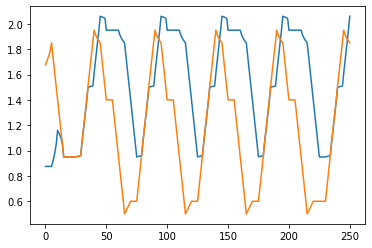

In [11]:
plt.subplot(1, 1, 1)
plt.plot(range(len(x)), x)
plt.plot(range(len(y)), y)

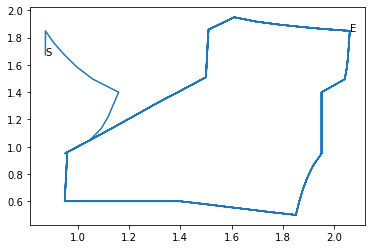

In [12]:
plt.subplot(1, 1, 1)
plt.plot(x, y)
plt.text(x[0], y[0], 'S')
plt.text(x[-1], y[-1], 'E');

## Animation

TBD.